# A Minimal Transformer Language Model (from scratch)

This notebook walks through a **small, fully transparent Transformer** trained on a toy text corpus.

The goal is **understanding**, not performance:
- word-level tokenization
- explicit self-attention
- teacher forcing for next-token prediction
- full training loop and diagnostics

All components are kept intentionally simple so that every tensor, token, and prediction can be inspected and understood.

In [1]:
# ==============================================================================
# Vocabulary definition
# ------------------------------------------------------------------------------
# - Maps integer token IDs → word strings
# - Token 0 is reserved for padding (empty string)
# - All other tokens represent whole words (no subword tokenization here)
# - This is a deliberately small, human-readable vocabulary for teaching
# ==============================================================================

vocab = {
    0: "",              # padding token (ignored in loss)
    1: "I", 2: "am", 3: "you", 4: "is", 5: "we", 6: "are",
    7: "a", 8: "an", 9: "the",
    10: "simple", 11: "example", 12: "with",
    13: "and", 14: "but", 15: "or",
    16: "not", 17: "only", 18: "also",
    19: "how", 20: "what", 21: "why",
    22: "can", 23: "must", 24: "should",
    25: "want", 26: "has", 27: "have", 28: "had",
    29: "to", 30: "home", 31: "play", 32: "in",
    33: "garden", 34: "weather", 35: "nice",
    36: "drives", 37: "Berlin", 38: "reads", 39: "book",
    40: "she", 41: "he", 42: "go",
    43: "hungry", 44: "tired", 45: "happy", 46: "sad",
    47: "it", 48: "good", 49: "this", 50: "bad",
    51: "eat", 52: "drink", 53: "come",
    54: "they", 55: "was"
}

# Vocabulary size
# Note: since IDs are contiguous, len(vocab) == max token ID + 1
vocab_size = len(vocab)
print("Vocabulary size:", vocab_size)


Vocabulary size: 56


In [2]:
# ==============================================================================
# Example training corpus
# ------------------------------------------------------------------------------
# - Very small toy dataset
# - Grammatically simple sentences
# - Covers different subjects, verbs, and objects
# - Used to demonstrate next-token prediction
# - NOT intended for generalization, only illustration
# ==============================================================================

sentences = [
    "I am hungry",
    "you are tired",
    "we are happy",
    "they are sad",
    "it is simple",
    "the weather is nice",
    "this is bad",
    "this was good",
    "we want to eat",
    "they want to drink",
    "you can come",
    "we go home",
    "they play in the garden",
    "the weather is nice",
    "he drives to Berlin",
    "she reads a book"
]

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# ==============================================================================
# Positional Encoding
# ------------------------------------------------------------------------------
# Adds explicit position information to token embeddings.
# Uses the standard sinusoidal formulation from Vaswani et al. (2017).
# ==============================================================================

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()

        # Precompute positional encodings (no trainable parameters)
        pe = torch.zeros(max_len, d_model)

        # Positions: [0, 1, 2, ..., max_len-1]
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        # Frequency scaling for sine/cosine
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() *
            (-math.log(10000.0) / d_model)
        )

        # Even dimensions: sine, odd dimensions: cosine
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Shape: (max_len, 1, d_model) for broadcasting
        pe = pe.unsqueeze(0).transpose(0, 1)

        # Register as buffer (saved with model, but not trainable)
        self.register_buffer("pe", pe)

    def forward(self, x):
        """
        x: Tensor of shape (batch_size, seq_len, d_model)
        """
        return x + self.pe[:x.size(0), :]


# ==============================================================================
# Multi-Head Self-Attention (manual implementation)
# ------------------------------------------------------------------------------
# Implements scaled dot-product attention with multiple heads.
# ==============================================================================

class SelfAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()

        assert d_model % num_heads == 0, \
            "d_model must be divisible by num_heads"

        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        # Linear projections for queries, keys, and values
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)

        # Final output projection
        self.out_linear = nn.Linear(d_model, d_model)

    def forward(self, x):
        """
        x: Tensor of shape (batch_size, seq_len, d_model)
        """
        batch_size = x.size(0)

        # ----------------------------------------------------------
        # Project and split into heads
        # Resulting shape:
        #   (batch_size, num_heads, seq_len, d_k)
        # ----------------------------------------------------------
        q = self.q_linear(x).view(
            batch_size, -1, self.num_heads, self.d_k
        ).transpose(1, 2)

        k = self.k_linear(x).view(
            batch_size, -1, self.num_heads, self.d_k
        ).transpose(1, 2)

        v = self.v_linear(x).view(
            batch_size, -1, self.num_heads, self.d_k
        ).transpose(1, 2)

        # ----------------------------------------------------------
        # Scaled dot-product attention
        # ----------------------------------------------------------
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)
        attention = F.softmax(scores, dim=-1)

        # ----------------------------------------------------------
        # Apply attention weights to values
        # ----------------------------------------------------------
        x = torch.matmul(attention, v)

        # ----------------------------------------------------------
        # Concatenate heads back together
        # ----------------------------------------------------------
        x = x.transpose(1, 2).contiguous().view(
            batch_size, -1, self.num_heads * self.d_k
        )

        # Final linear projection
        return self.out_linear(x)


# ==============================================================================
# Position-wise Feedforward Network
# ------------------------------------------------------------------------------
# Applies the same MLP independently to each token position.
# ==============================================================================

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048):
        super().__init__()

        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.linear2(F.relu(self.linear1(x)))


# ==============================================================================
# Transformer Block
# ------------------------------------------------------------------------------
# Self-attention + residual + layer norm
# Feedforward + residual + layer norm
# ==============================================================================

class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff):
        super().__init__()

        self.attention = SelfAttention(d_model, num_heads)
        self.ff = FeedForward(d_model, d_ff)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        # Self-attention sublayer
        attn_out = self.attention(x)
        x = self.norm1(x + attn_out)

        # Feedforward sublayer
        ff_out = self.ff(x)
        x = self.norm2(x + ff_out)

        return x


# ==============================================================================
# Full Transformer Language Model
# ------------------------------------------------------------------------------
# Embedding → positional encoding → stacked Transformer blocks → vocabulary logits
# ==============================================================================

class SimpleTransformer(nn.Module):
    def __init__(self, d_model, num_heads, num_layers,
                 vocab_size, max_len, d_ff=2048):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_len)

        self.layers = nn.ModuleList([
            TransformerBlock(d_model, num_heads, d_ff)
            for _ in range(num_layers)
        ])

        # Final projection to vocabulary
        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        """
        x: Tensor of token IDs, shape (batch_size, seq_len)
        """
        # Token embeddings + positional encoding
        x = self.embedding(x)
        x = self.positional_encoding(x)

        # Transformer layers
        for layer in self.layers:
            x = layer(x)

        # Vocabulary logits for next-token prediction
        return self.fc_out(x)


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# ==============================================================================
# Tokenization utilities
# ------------------------------------------------------------------------------
# - Word-level tokenization using the predefined vocabulary
# - No subword units, no OOV handling (intentional simplification)
# ==============================================================================

def tokenize_sentence(sentence, vocab):
    """
    Convert a sentence into a list of token IDs.
    Assumes every word is present in the vocabulary.
    """
    return [
        key
        for word in sentence.split()
        for key, value in vocab.items()
        if value == word
    ]


def pad_sequence(seq, max_len, pad_value=0):
    """
    Pad or truncate a token sequence to a fixed length.
    Padding token ID = 0.
    """
    if len(seq) < max_len:
        return seq + [pad_value] * (max_len - len(seq))
    else:
        return seq[:max_len]


# ==============================================================================
# Dataset for next-token prediction
# ------------------------------------------------------------------------------
# Each sample:
#   x = tokens[:-1]  (input sequence)
#   y = tokens[:]    (target sequence)
# This implements teacher forcing.
# ==============================================================================

class SimpleDataset(Dataset):
    def __init__(self, sentences, vocab, max_len):
        self.sentences = sentences
        self.vocab = vocab
        self.max_len = max_len

        # Tokenize all sentences once
        self.data = [
            tokenize_sentence(sentence, vocab)
            for sentence in sentences
        ]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sequence = self.data[idx]

        # Input: all tokens except the last
        x = sequence[:-1]

        # Target: full sequence (predict next token at each position)
        y = sequence

        # Pad both to the same length
        x_padded = pad_sequence(x, self.max_len)
        y_padded = pad_sequence(y, self.max_len)

        return (
            torch.tensor(x_padded, dtype=torch.long),
            torch.tensor(y_padded, dtype=torch.long),
        )


# ==============================================================================
# Dataset and DataLoader
# ==============================================================================

max_len = 6  # maximum sequence length (short sentences)

dataset = SimpleDataset(sentences, vocab, max_len)

dataloader = DataLoader(
    dataset,
    batch_size=6,
    shuffle=True
)


# ==============================================================================
# Model configuration
# ------------------------------------------------------------------------------
# Small dimensions on purpose:
# - fast training
# - easy to inspect
# - suitable for live demos
# ==============================================================================

vocab_size = len(vocab)

d_model = 32     # embedding dimension
num_heads = 2    # number of attention heads
num_layers = 2   # number of Transformer blocks

model = SimpleTransformer(
    d_model=d_model,
    num_heads=num_heads,
    num_layers=num_layers,
    vocab_size=vocab_size,
    max_len=max_len
)


# ==============================================================================
# Weight initialization
# ------------------------------------------------------------------------------
# Xavier initialization for all linear layers
# ==============================================================================

def initialize_weights(module):
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            nn.init.zeros_(module.bias)

model.apply(initialize_weights)


# ==============================================================================
# Loss function and optimizer
# ------------------------------------------------------------------------------
# - Cross-entropy over vocabulary
# - Padding token (0) is ignored in the loss
# ==============================================================================

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [5]:
# ==============================================================================
# Training loop
# ------------------------------------------------------------------------------
# - Standard supervised training
# - Next-token prediction with teacher forcing
# - Loss is accumulated for monitoring
# ==============================================================================

num_epochs = 101          # number of training epochs
loss_history = []         # store loss values for plotting

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    # --------------------------------------------------------------------------
    # Iterate over mini-batches
    # --------------------------------------------------------------------------
    for x, y in dataloader:

        # Reset gradients from previous step
        optimizer.zero_grad()

        # Forward pass: logits over vocabulary
        logits = model(x)

        # Compute cross-entropy loss
        # Flatten batch and sequence dimensions
        loss = criterion(
            logits.view(-1, vocab_size),
            y.view(-1)
        )

        # Safety check (numerical stability)
        if torch.isnan(loss):
            print("NaN detected — stopping training.")
            break

        # Backpropagation
        loss.backward()

        # Gradient clipping to stabilize training
        torch.nn.utils.clip_grad_norm_(
            model.parameters(), max_norm=1.0
        )

        # Parameter update
        optimizer.step()

        # Bookkeeping
        loss_value = loss.item()
        loss_history.append(loss_value)
        epoch_loss += loss_value

    # --------------------------------------------------------------------------
    # Progress reporting (every epoch)
    # --------------------------------------------------------------------------
    avg_loss = epoch_loss / len(dataloader)
    if epoch%10==0: 
       print(f"Epoch {epoch+1:3d}/{num_epochs}, loss = {avg_loss:.4f}")


Epoch   1/101, loss = 4.3124
Epoch  11/101, loss = 0.9470
Epoch  21/101, loss = 0.3529
Epoch  31/101, loss = 0.1712
Epoch  41/101, loss = 0.1101
Epoch  51/101, loss = 0.0791
Epoch  61/101, loss = 0.0609
Epoch  71/101, loss = 0.0464
Epoch  81/101, loss = 0.0373
Epoch  91/101, loss = 0.0310
Epoch 101/101, loss = 0.0258


Number of training steps recorded: 303


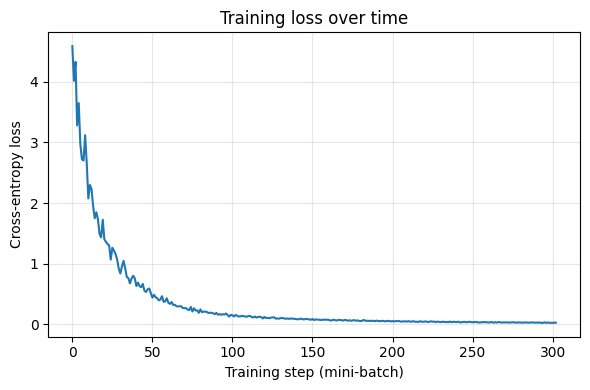

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# ==============================================================================
# Training diagnostics: loss history
# ------------------------------------------------------------------------------
# Visualizes how the training loss evolves over time.
# Each entry corresponds to one optimizer step (mini-batch).
# ==============================================================================

# Number of recorded training steps
num_steps = len(loss_history)
print("Number of training steps recorded:", num_steps)

# Create the loss plot
plt.figure(figsize=(6, 4))
plt.plot(loss_history, linewidth=1.5)

plt.xlabel("Training step (mini-batch)")
plt.ylabel("Cross-entropy loss")
plt.title("Training loss over time")

plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()


In [7]:
# ----------------------------------------------------------------------------
# Testing the trained Transformer model (with token inspection)
# ----------------------------------------------------------------------------
from IPython.display import HTML, display

def color_text(text, color="black"):
    """Display colored HTML text in Jupyter."""
    display(HTML(f"<span style='color:{color}'>{text}</span>"))

model.eval()

print("=" * 90)
print("MODEL EVALUATION — WORDS AND TOKEN IDS")
print("=" * 90)

for sentence in sentences:
    # ------------------------------------------------------------------------
    # Tokenize
    # ------------------------------------------------------------------------
    tokens = tokenize_sentence(sentence, vocab)
    seq_len = len(tokens)

    # Input to model: shifted sequence (teacher forcing)
    x = pad_sequence(tokens[:-1], max_len)
    x_tensor = torch.tensor(x).unsqueeze(0)

    # ------------------------------------------------------------------------
    # Forward pass
    # ------------------------------------------------------------------------
    with torch.no_grad():
        logits = model(x_tensor)

    y_pred = torch.argmax(logits, dim=-1)[:, :seq_len]

    # ------------------------------------------------------------------------
    # Decode
    # ------------------------------------------------------------------------
    words_target = sentence.split()
    words_input  = [vocab[i] for i in x]
    words_output = [vocab[i.item()] for i in y_pred.squeeze()]

    # ------------------------------------------------------------------------
    # Display
    # ------------------------------------------------------------------------
    print("-" * 90)
    print(f"Target sentence:")
    print(f"  words : {' '.join(words_target)}")
    print(f"  tokens: {tokens}")

    print("\nModel input (shifted):")
    print(f"  words : {' '.join(words_input)}")
    print(f"  tokens: {x}")

    print("\nModel prediction:")
    print(f"  words : {' '.join(words_output)}")
    print(f"  tokens: {y_pred.squeeze().tolist()}")

    success = (" ".join(words_output) == sentence)
    color = "green" if success else "red"
    color_text(f"Result: {success}", color)

print("-" * 90)


MODEL EVALUATION — WORDS AND TOKEN IDS
------------------------------------------------------------------------------------------
Target sentence:
  words : I am hungry
  tokens: [1, 2, 43]

Model input (shifted):
  words : I am    
  tokens: [1, 2, 0, 0, 0, 0]

Model prediction:
  words : I am hungry
  tokens: [1, 2, 43]


------------------------------------------------------------------------------------------
Target sentence:
  words : you are tired
  tokens: [3, 6, 44]

Model input (shifted):
  words : you are    
  tokens: [3, 6, 0, 0, 0, 0]

Model prediction:
  words : you are tired
  tokens: [3, 6, 44]


------------------------------------------------------------------------------------------
Target sentence:
  words : we are happy
  tokens: [5, 6, 45]

Model input (shifted):
  words : we are    
  tokens: [5, 6, 0, 0, 0, 0]

Model prediction:
  words : we are happy
  tokens: [5, 6, 45]


------------------------------------------------------------------------------------------
Target sentence:
  words : they are sad
  tokens: [54, 6, 46]

Model input (shifted):
  words : they are    
  tokens: [54, 6, 0, 0, 0, 0]

Model prediction:
  words : they are sad
  tokens: [54, 6, 46]


------------------------------------------------------------------------------------------
Target sentence:
  words : it is simple
  tokens: [47, 4, 10]

Model input (shifted):
  words : it is    
  tokens: [47, 4, 0, 0, 0, 0]

Model prediction:
  words : it is simple
  tokens: [47, 4, 10]


------------------------------------------------------------------------------------------
Target sentence:
  words : the weather is nice
  tokens: [9, 34, 4, 35]

Model input (shifted):
  words : the weather is   
  tokens: [9, 34, 4, 0, 0, 0]

Model prediction:
  words : the weather is nice
  tokens: [9, 34, 4, 35]


------------------------------------------------------------------------------------------
Target sentence:
  words : this is bad
  tokens: [49, 4, 50]

Model input (shifted):
  words : this is    
  tokens: [49, 4, 0, 0, 0, 0]

Model prediction:
  words : this is bad
  tokens: [49, 4, 50]


------------------------------------------------------------------------------------------
Target sentence:
  words : this was good
  tokens: [49, 55, 48]

Model input (shifted):
  words : this was    
  tokens: [49, 55, 0, 0, 0, 0]

Model prediction:
  words : this was good
  tokens: [49, 55, 48]


------------------------------------------------------------------------------------------
Target sentence:
  words : we want to eat
  tokens: [5, 25, 29, 51]

Model input (shifted):
  words : we want to   
  tokens: [5, 25, 29, 0, 0, 0]

Model prediction:
  words : we want to eat
  tokens: [5, 25, 29, 51]


------------------------------------------------------------------------------------------
Target sentence:
  words : they want to drink
  tokens: [54, 25, 29, 52]

Model input (shifted):
  words : they want to   
  tokens: [54, 25, 29, 0, 0, 0]

Model prediction:
  words : they want to drink
  tokens: [54, 25, 29, 52]


------------------------------------------------------------------------------------------
Target sentence:
  words : you can come
  tokens: [3, 22, 53]

Model input (shifted):
  words : you can    
  tokens: [3, 22, 0, 0, 0, 0]

Model prediction:
  words : you can come
  tokens: [3, 22, 53]


------------------------------------------------------------------------------------------
Target sentence:
  words : we go home
  tokens: [5, 42, 30]

Model input (shifted):
  words : we go    
  tokens: [5, 42, 0, 0, 0, 0]

Model prediction:
  words : we go home
  tokens: [5, 42, 30]


------------------------------------------------------------------------------------------
Target sentence:
  words : they play in the garden
  tokens: [54, 31, 32, 9, 33]

Model input (shifted):
  words : they play in the  
  tokens: [54, 31, 32, 9, 0, 0]

Model prediction:
  words : they play in the garden
  tokens: [54, 31, 32, 9, 33]


------------------------------------------------------------------------------------------
Target sentence:
  words : the weather is nice
  tokens: [9, 34, 4, 35]

Model input (shifted):
  words : the weather is   
  tokens: [9, 34, 4, 0, 0, 0]

Model prediction:
  words : the weather is nice
  tokens: [9, 34, 4, 35]


------------------------------------------------------------------------------------------
Target sentence:
  words : he drives to Berlin
  tokens: [41, 36, 29, 37]

Model input (shifted):
  words : he drives to   
  tokens: [41, 36, 29, 0, 0, 0]

Model prediction:
  words : he drives to Berlin
  tokens: [41, 36, 29, 37]


------------------------------------------------------------------------------------------
Target sentence:
  words : she reads a book
  tokens: [40, 38, 7, 39]

Model input (shifted):
  words : she reads a   
  tokens: [40, 38, 7, 0, 0, 0]

Model prediction:
  words : she reads a book
  tokens: [40, 38, 7, 39]


------------------------------------------------------------------------------------------


In [8]:
# ==============================================================================
# Dataset inspection and sanity check
# ------------------------------------------------------------------------------
# This cell explores:
# - how sentences are tokenized
# - how input (x) and target (y) are constructed
# - how padding is applied
# ==============================================================================

# Create the dataset
dataset = SimpleDataset(sentences, vocab, max_len)

print("=" * 90)
print("RAW SENTENCES")
print("=" * 90)
for s in sentences:
    print(" ", s)

print("\n" + "=" * 90)
print("DATASET ENTRIES (x = input, y = target)")
print("=" * 90)

for i in range(len(dataset)):
    x, y = dataset[i]

    # Decode token IDs back to words
    decoded_x = [vocab[token.item()] for token in x]
    decoded_y = [vocab[token.item()] for token in y]

    print("-" * 90)
    print(f"Sample {i}")

    print("Input  x (teacher forcing):")
    print(f"  tokens: {x.tolist()}")
    print(f"  words : {' '.join(decoded_x)}")

    print("Target y (next-token prediction):")
    print(f"  tokens: {y.tolist()}")
    print(f"  words : {' '.join(decoded_y)}")

    print("Original sentence:")
    print(f"  {' '.join(sentences[i].split())}")

print("-" * 90)


RAW SENTENCES
  I am hungry
  you are tired
  we are happy
  they are sad
  it is simple
  the weather is nice
  this is bad
  this was good
  we want to eat
  they want to drink
  you can come
  we go home
  they play in the garden
  the weather is nice
  he drives to Berlin
  she reads a book

DATASET ENTRIES (x = input, y = target)
------------------------------------------------------------------------------------------
Sample 0
Input  x (teacher forcing):
  tokens: [1, 2, 0, 0, 0, 0]
  words : I am    
Target y (next-token prediction):
  tokens: [1, 2, 43, 0, 0, 0]
  words : I am hungry   
Original sentence:
  I am hungry
------------------------------------------------------------------------------------------
Sample 1
Input  x (teacher forcing):
  tokens: [3, 6, 0, 0, 0, 0]
  words : you are    
Target y (next-token prediction):
  tokens: [3, 6, 44, 0, 0, 0]
  words : you are tired   
Original sentence:
  you are tired
------------------------------------------------------------

In [9]:
# ==============================================================================
# Inspecting batches produced by the DataLoader
# ------------------------------------------------------------------------------
# This cell shows:
# - how individual samples are grouped into batches
# - the effect of shuffling
# - padding at batch level
# ==============================================================================

for batch_idx, (x, y) in enumerate(dataloader):
    print("=" * 90)
    print(f"BATCH {batch_idx}")
    print("=" * 90)

    print("Inputs x (teacher forcing):")
    for i, seq in enumerate(x):
        decoded_x = [vocab[token.item()] for token in seq]
        print(f"  sample {i:2d}: {' '.join(decoded_x)}")

    print("\nTargets y (next-token labels):")
    for i, seq in enumerate(y):
        decoded_y = [vocab[token.item()] for token in seq]
        print(f"  sample {i:2d}: {' '.join(decoded_y)}")


BATCH 0
Inputs x (teacher forcing):
  sample  0: we go    
  sample  1: the weather is   
  sample  2: I am    
  sample  3: you can    
  sample  4: it is    
  sample  5: she reads a   

Targets y (next-token labels):
  sample  0: we go home   
  sample  1: the weather is nice  
  sample  2: I am hungry   
  sample  3: you can come   
  sample  4: it is simple   
  sample  5: she reads a book  
BATCH 1
Inputs x (teacher forcing):
  sample  0: we want to   
  sample  1: this is    
  sample  2: they want to   
  sample  3: he drives to   
  sample  4: they are    
  sample  5: they play in the  

Targets y (next-token labels):
  sample  0: we want to eat  
  sample  1: this is bad   
  sample  2: they want to drink  
  sample  3: he drives to Berlin  
  sample  4: they are sad   
  sample  5: they play in the garden 
BATCH 2
Inputs x (teacher forcing):
  sample  0: you are    
  sample  1: the weather is   
  sample  2: we are    
  sample  3: this was    

Targets y (next-token label

In [10]:
# ==============================================================================
# Sanity check: tokenization, padding, and decoding
# ------------------------------------------------------------------------------
# This cell verifies that:
# - words are mapped to the correct token IDs
# - sequences are padded consistently
# - decoding recovers the original sentence (up to padding)
# ==============================================================================

# ----------------------------------------------------------------------
# 1. Print vocabulary (token ID → word)
# ----------------------------------------------------------------------
print("=" * 90)
print("VOCABULARY (token ID → word)")
print("=" * 90)

for token_id in range(1, len(vocab)):  # skip padding token 0
    print(f"{token_id:2d}: {vocab[token_id]:<10}", end="  ")
    if token_id % 10 == 0:
        print()
print("\n")

# ----------------------------------------------------------------------
# 2. Tokenize and pad all sentences
# ----------------------------------------------------------------------
max_len = 6

tokenized_padded = [
    pad_sequence(tokenize_sentence(sentence, vocab), max_len=max_len)
    for sentence in sentences
]

# ----------------------------------------------------------------------
# 3. Step-by-step inspection per sentence
# ----------------------------------------------------------------------
print("=" * 90)
print("TOKENIZATION → PADDING → DECODING")
print("=" * 90)

for sentence in sentences:
    print("-" * 90)
    print(f"Original sentence:")
    print(f"  {sentence}")

    # Tokenization
    tokens = tokenize_sentence(sentence, vocab)
    print(f"Tokenized:")
    print(f"  {tokens}")

    # Padding
    padded = pad_sequence(tokens, max_len=max_len)
    print(f"Padded:")
    print(f"  {padded}")

    # Decoding
    decoded = [vocab[token_id] for token_id in padded]
    print(f"Decoded:")
    print(f"  {' '.join(decoded)}")

# ----------------------------------------------------------------------
# 4. Final dataset-style view
# ----------------------------------------------------------------------
print("\n" + "=" * 90)
print("FINAL DATA REPRESENTATION (as seen by the model)")
print("=" * 90)

for i, seq in enumerate(tokenized_padded):
    decoded_seq = [vocab[token_id] for token_id in seq]

    print(f"Sample {i:2d}:")
    print(f"  tokens : {seq}")
    print(f"  words  : {' '.join(decoded_seq)}")
    print(f"  source : {sentences[i]}")
    print()


VOCABULARY (token ID → word)
 1: I            2: am           3: you          4: is           5: we           6: are          7: a            8: an           9: the         10: simple      
11: example     12: with        13: and         14: but         15: or          16: not         17: only        18: also        19: how         20: what        
21: why         22: can         23: must        24: should      25: want        26: has         27: have        28: had         29: to          30: home        
31: play        32: in          33: garden      34: weather     35: nice        36: drives      37: Berlin      38: reads       39: book        40: she         
41: he          42: go          43: hungry      44: tired       45: happy       46: sad         47: it          48: good        49: this        50: bad         
51: eat         52: drink       53: come        54: they        55: was         

TOKENIZATION → PADDING → DECODING
--------------------------------------------------

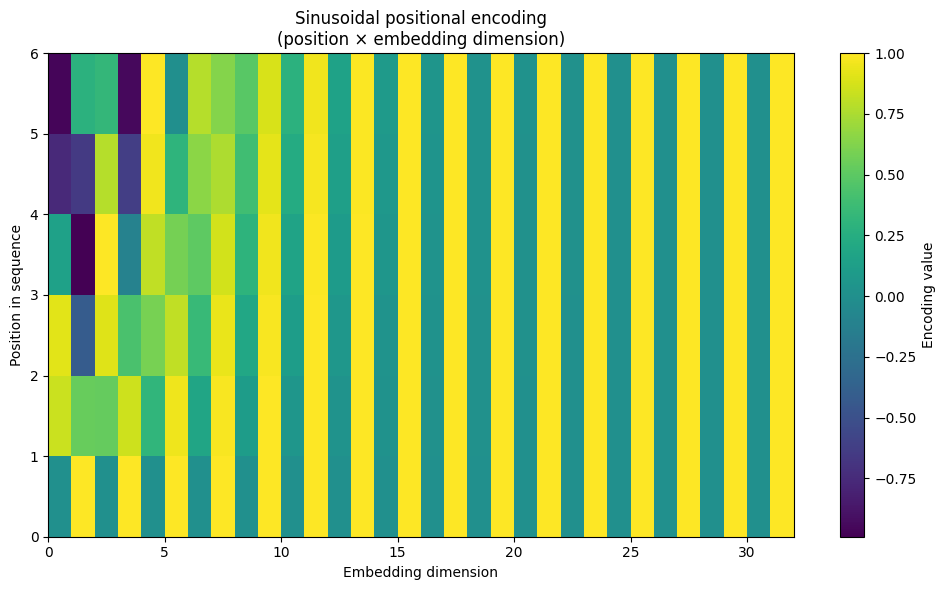

In [11]:
# ==============================================================================
# Visualization of positional encodings
# ------------------------------------------------------------------------------
# This cell illustrates how positional information is encoded and added to
# token embeddings in the Transformer.
# ==============================================================================

import matplotlib.pyplot as plt

# ----------------------------------------------------------------------
# 1. Instantiate positional encoding layer
# ----------------------------------------------------------------------
# d_model : embedding dimension
# max_len : maximum sequence length
pos_encoding_layer = PositionalEncoding(d_model, max_len)

# ----------------------------------------------------------------------
# 2. Extract the precomputed positional encoding matrix
# ----------------------------------------------------------------------
# Stored as a buffer of shape:
#   (max_len, 1, d_model)
# We squeeze the singleton dimension for visualization.
pos_encoding = pos_encoding_layer.pe.squeeze(1).numpy()

# ----------------------------------------------------------------------
# 3. Plot the positional encoding as a heatmap
# ----------------------------------------------------------------------
plt.figure(figsize=(10, 6))

plt.pcolormesh(
    pos_encoding,
    cmap="viridis",
    shading="auto"
)

plt.xlabel("Embedding dimension")
plt.ylabel("Position in sequence")

plt.xlim(0, d_model)
plt.ylim(0, max_len)

plt.colorbar(label="Encoding value")

plt.title("Sinusoidal positional encoding\n(position × embedding dimension)")

plt.tight_layout()
plt.show()
